# Project: Web Traffic Forecasting
Ruoxin Jiang and Bingyan Hu
## Overview
___
### Task
The goal of our project is to forecast web traffic time series for online pages. Forecasting time series is challenging since we need to combine its seasonality, trend and other factors intelligently in modeling; the historical data itself is insufficient to capture uncertainty in future events. 

We present a hierchical time series forecasting model using Edward and demostrate three rounds of Box's loop below.

+ Hypothesis

### Data Source
We obtain real time series data from [a recent Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting). Each time series represents daily page views of a particular Wikipedia article from **07/01/2015** to **09/10/2017**. 

The model is trained on data before **07/10/2017** and we forecast number of page visits in last 60 days from **07/10/2017** to **09/10/2017**.

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

from models import *
from utils import *
from pipeline import *
from cross_validation import cross_validation

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (24, 12)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.color'] = 'b'

## Round 1: 
___
### 1.Data
We randomly pick a wikipedia article data with `ds` and `views` in long format.

+ selection

In [2]:
# Load data into DataFrame
FPATH = "./data/nfl_teams.csv"
pages = ["Atlanta_Falcons_en.wikipedia.org_mobile-web_all-agents", 
         "Dallas_Cowboys_en.wikipedia.org_mobile-web_all-agents"]

timeseries = get_timeseries(FPATH)
ts_dfs = []
for p in pages:
    print("Preparing timeseries %s" % p)
    df = setup_dataframe(timeseries[p])
    ts_dfs.append(df)

Loading timeseries:
Preparing timeseries Atlanta_Falcons_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Dallas_Cowboys_en.wikipedia.org_mobile-web_all-agents


[+] History: 741, Future: 62


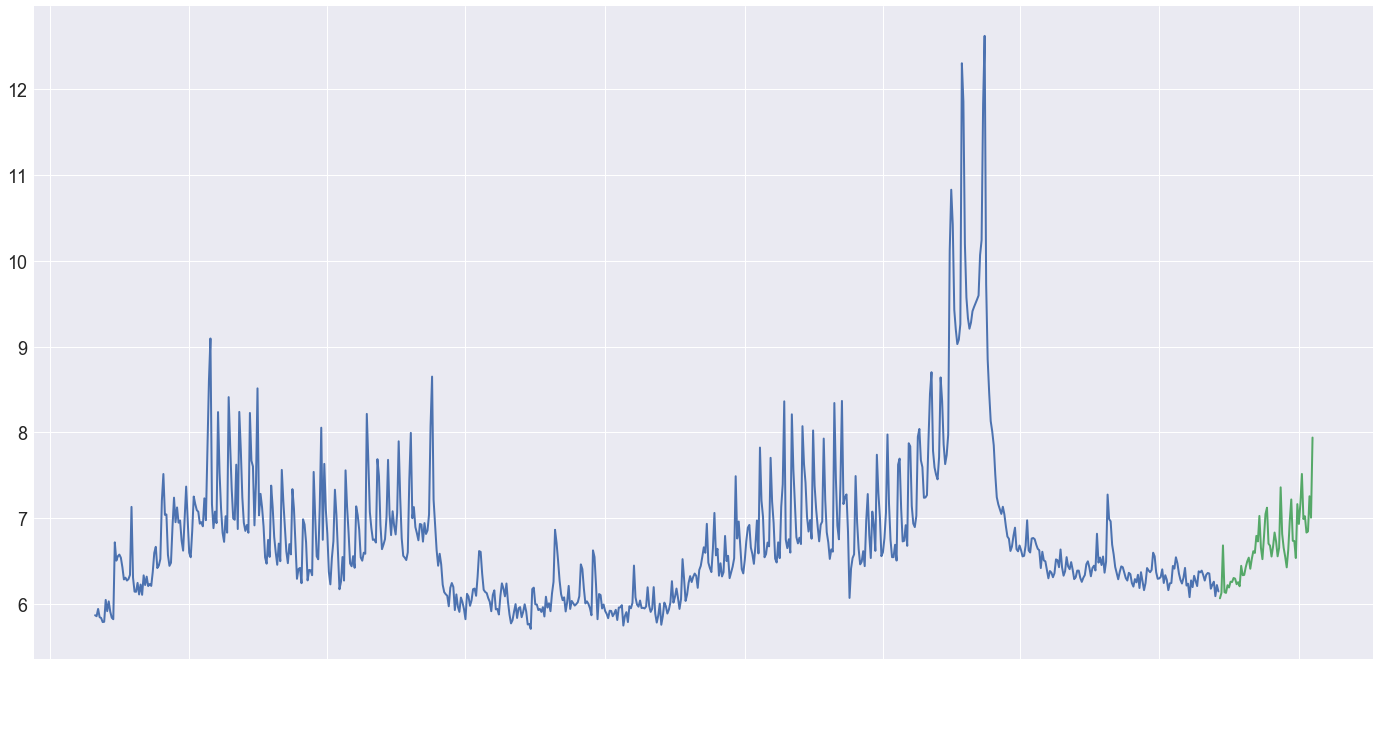

[+] History: 741, Future: 62


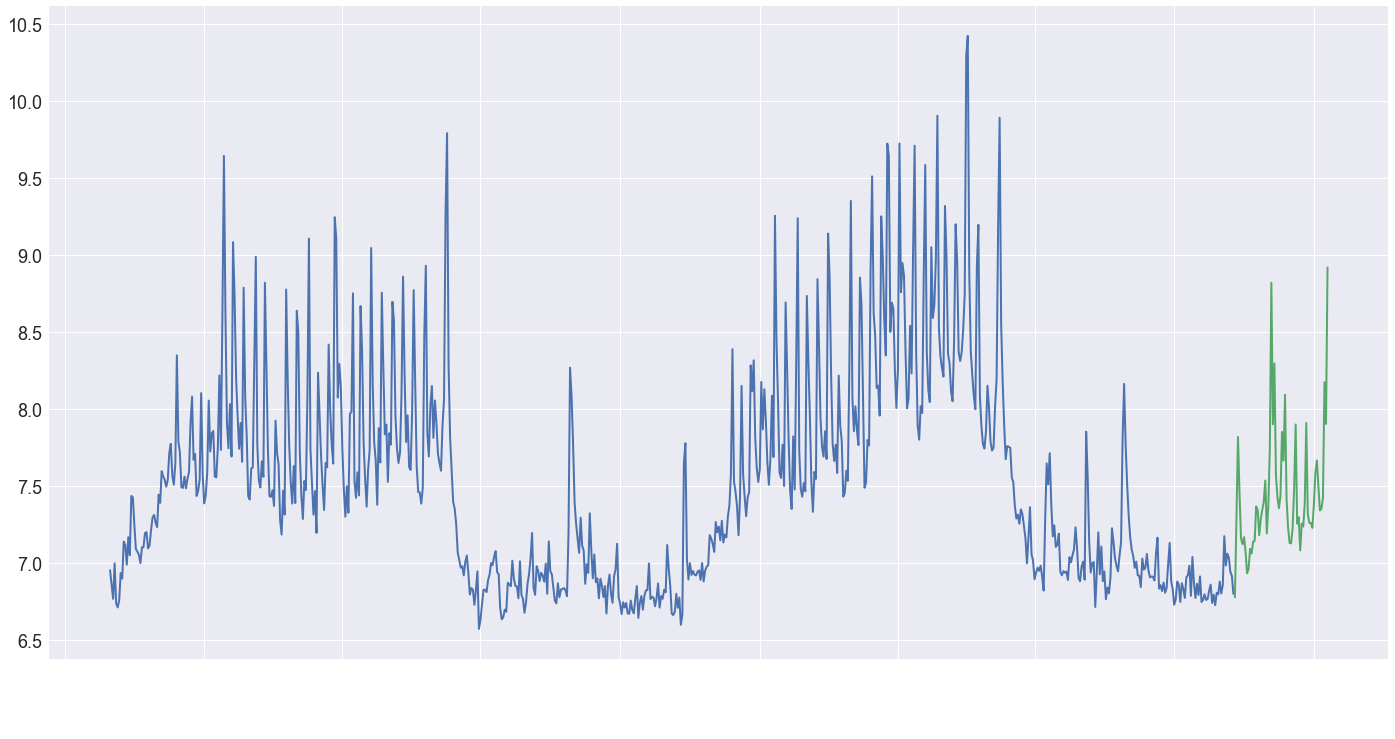

Extracting features
[+] 26 Seasonal features
	[+] ['yearly_delim_1', 'yearly_delim_2', 'yearly_delim_3', 'yearly_delim_4', 'yearly_delim_5', 'yearly_delim_6', 'yearly_delim_7', 'yearly_delim_8', 'yearly_delim_9', 'yearly_delim_10', 'yearly_delim_11', 'yearly_delim_12', 'yearly_delim_13', 'yearly_delim_14', 'yearly_delim_15', 'yearly_delim_16', 'yearly_delim_17', 'yearly_delim_18', 'yearly_delim_19', 'yearly_delim_20', 'weekly_delim_1', 'weekly_delim_2', 'weekly_delim_3', 'weekly_delim_4', 'weekly_delim_5', 'weekly_delim_6']
[+] 25 changepoints
	 [ 0.03243243  0.06351351  0.09594595  0.12837838  0.15945946  0.19189189
  0.22432432  0.25540541  0.28783784  0.32027027  0.35135135  0.38378378
  0.41621622  0.44864865  0.47972973  0.51216216  0.54459459  0.57567568
  0.60810811  0.64054054  0.67162162  0.70405405  0.73648649  0.76756757
  0.8       ]
[+] 26 Seasonal features
	[+] ['yearly_delim_1', 'yearly_delim_2', 'yearly_delim_3', 'yearly_delim_4', 'yearly_delim_5', 'yearly_delim_6', 'ye

In [3]:
# Split history (train) and future (test)
sdate = pd.datetime(2017, 7, 10)
ts_data = []
for df in ts_dfs: 
    history, future, y_scale = split_train_test(df, sdate)
    ts_data.append({
        "history": history, "future": future, "y_scale": y_scale
    })
    
print("Extracting features")
ts = ts_data[0] # same feature matrix for all test series  
train_data = extract_features(ts["history"])
test_data = extract_features(ts["future"], changepoints_t=train_data["t_change"])
assert(all(train_data["X"].columns ==  test_data["X"].columns))
assert(all(train_data["t_change"] == test_data["t_change"]))

## Model: FB prophet regression model
We build a regression model similar to [Facebook Prophet](https://peerj.com/preprints/3190/); it combines trend, seasonality and holiday components with non-linear smoothers applied to regressors $t \in \mathbb{Z}^{T}$. 

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}  $$

- **Trend** <br/> $$g(t) = (k + \mathbf{a}(t)^{T} \boldsymbol{\delta})t + (m + \mathbf{a}(t)^{T} \boldsymbol{\gamma})$$
    - $k$ is the growth rate (slope)
    - $m$ is the offset (intercept)
    - $S$ changepoints are explicitly defined to allow trend changes at times $s_{j \in {1,2,...,S}}$
        - $\mathbf{a}(t) \in \{0,1\}^{S}$ are changepoint indicators
        - $\delta_{j} \sim Laplace(0,\tau)$ is the change of rate at time $s_{j}$
        - $\gamma_{j}$ is set to $-s_{j}\delta_{j}$ to make the function continuous</br>


- **Seasonality** <br/>
We construct Fourier series to approximate periodic seaonality.
$$s(t) = \sum_{n=1}^{N}(a_{n}cos(\frac{2\pi nt}{P}) + b_{n}sin(\frac{2\pi nt}{P} )) = X(t)  \boldsymbol{\beta}$$
    - $\boldsymbol{\beta} = [a_{1}, b_{1} , ... , a_{N}, b_{N}]^{T}$ and $\boldsymbol{\beta} \sim Normal(0,\sigma^{2})$
    - yearly -> (P = 365.25, N = 10)
    - weekly -> (P = 7, N = 3)
    

- **Holiday/Events** <br/>
Assuming holidays are independnet, we assign each holiday with a parameter $\kappa_{i}$
$$h(t) = Z(t) \boldsymbol{\kappa}$$
    - $Z(t) = [\boldsymbol{1}(t\in D_{1}) , ... , \boldsymbol{1}(t\in D_{L})]$
    - $\boldsymbol{\kappa} \sim Normal(0, \nu^2)$

Before modeling, we transform the raw data and extract features into proper format. The input data includes

- X
    - **t: ** time index
    - **X: ** seasonality vector after fourier transformation
    - **A: ** changepoint vector given time and number of change points
    - **sigmas: ** fixed scale on seasonality priors
- y
    - **y_scaled: ** `maxdiff(log(views))`

In [4]:
N_TS = len(ts_data)
S = len(train_data["t_change"])
K = train_data["X"].shape[1] #

t = tf.placeholder(tf.float32, shape=None, name="t")              # time index
A = tf.placeholder(tf.float32, shape=(None, S), name="A")         # changepoint indicators
t_change = tf.placeholder(tf.float32, shape=(S), name="t_change") # changepoints_t
X = tf.placeholder(tf.float32, shape=(None, K), name="X")         # season vectors
sigmas = tf.placeholder(tf.float32, shape=(K,), name="sigmas")    # scale on seasonality prior
        
k = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))     # initial slope
m = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))     # initial intercept

sigma_obs = Normal(loc=tf.zeros(1), scale=0.5*tf.ones(1))   # noise
tau = Normal(loc=tf.ones(1) * 0.05, scale=1.*tf.ones(1))    # changepoint prior scale
delta = Laplace(loc=tf.zeros(S), scale=tau*tf.ones(S))    # changepoint rate adjustment
gamma = tf.multiply(-t_change, delta)
beta = Normal(loc=tf.zeros(K), scale=sigmas*tf.ones(K))      # seasonal
trend_loc = (k + ed.dot(A, delta)) * t + \
            (m + ed.dot(A, gamma))
seas_loc = ed.dot(X, beta)
y = Normal(loc = trend_loc + seas_loc, scale = sigma_obs)

### 1.Inference: HMC
Given train data, the goal is to infer $k,m,\boldsymbol{\delta},\tau,\boldsymbol{\beta}$ and $\sigma$, where k and m are trend model parameters, $\boldsymbol{\delta}$ are latent variables for rate adjustment, $\boldsymbol{\beta}$ are smoothers for seasonality, $\tau$ and $\sigma$ are variance component parameters.

In this analysis, we use Monte Carlo with `ed.HMC` to infer all the latent variables. All training data are passed in for inference and we tune step_size $= 0.0005$, n_steps $= 2$.

In [5]:
ITR = 5000
#def init_km(df):
#    return 0., df['y_scaled'].median()

kinit, minit = init_km(ts_data[0]["history"])
print("[+] Initial slope / intercept: %f, %f" % (kinit, minit))
qk = Empirical(params=tf.Variable(kinit * tf.ones([ITR, 1])))
qm = Empirical(params=tf.Variable(minit * tf.ones([ITR, 1])))
qsigma_obs = Empirical(params=tf.Variable(tf.ones([ITR, 1])))
qbeta = Empirical(params=tf.Variable(tf.zeros([ITR, K])))
qdelta = Empirical(params=tf.Variable(tf.zeros([ITR, S])))
qtau = Empirical(params=tf.Variable(0.05 * tf.ones([ITR, 1])))

[+] Initial slope / intercept: 0.000000, 0.518372


In [6]:
posts_dict = {
    k: qk, m: qm, sigma_obs: qsigma_obs,
    beta: qbeta, delta: qdelta, 
    tau: qtau
}

data_dict = {
    y: ts_data[0]["history"]["y_scaled"].as_matrix(),
    t: train_data["t"],
    X: train_data["X"],
    sigmas: train_data["sigmas"],
    A: train_data["A"],
    t_change: train_data["t_change"]
}

inference = ed.HMC(posts_dict, data=data_dict)
STEP_SIZE = 5e-4
N_STEPS = 2
inference.run(step_size=STEP_SIZE)#, n_steps=N_STEPS

5000/5000 [100%] ██████████████████████████████ Elapsed: 68s | Acceptance Rate: 0.961


### 1.Prediction

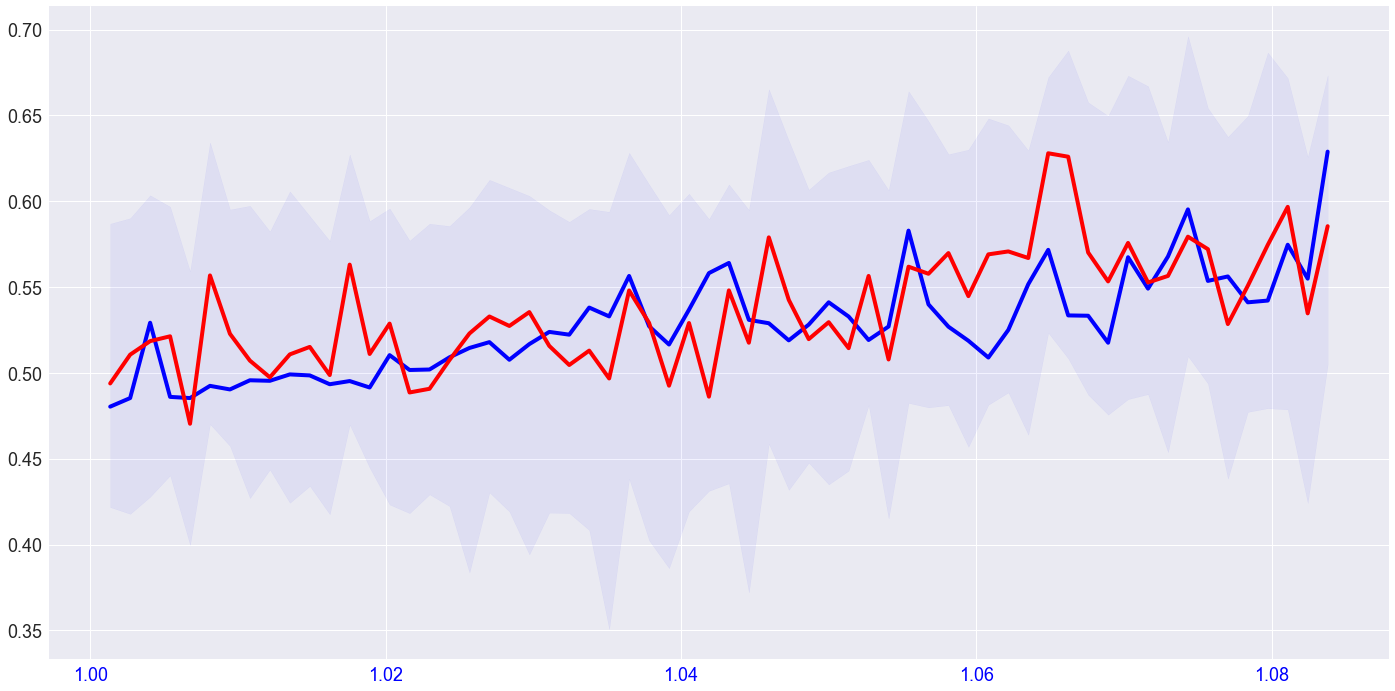

In [54]:
test_data_dict =  {
    t: test_data["t"],
    X: test_data["X"],
    sigmas: test_data["sigmas"],
    A: test_data["A"],
    t_change: test_data["t_change"]
}
CI = [20, 80]
y_true = ts_data[0]["future"]["y_scaled"]
y_pred = predict(y, posts_dict, test_data_dict,SAMPLE=500)
y_pred_mean = np.mean(y_pred, axis=0)[0]
y_pred_lower = np.percentile(y_pred, CI, axis=0)[0][0]
y_pred_upper = np.percentile(y_pred, CI, axis=0)[1][0]
plt.plot(ts_data[0]["future"]["t"], y_true,lw=4, color='b')
plt.plot(ts_data[0]["future"]["t"], y_pred_mean,lw=4, color='r')
# plt.plot(ts_data[0]["future"]["ds"], y_pred_lower)
# plt.plot(ts_data[0]["future"]["ds"], y_pred_upper)
plt.fill_between(ts_data[0]["future"]["t"], y_pred_lower,y_pred_upper,color='b',alpha=.05)
plt.show()

### 1.Criticism
- Visualization of the residuals
- Pointwise Evaluation
    - MAPE
    - SMAPE
    - MSE
- PPC

MAPE = 4.970587
SMAPE = 4.911069
MSE = 0.001077


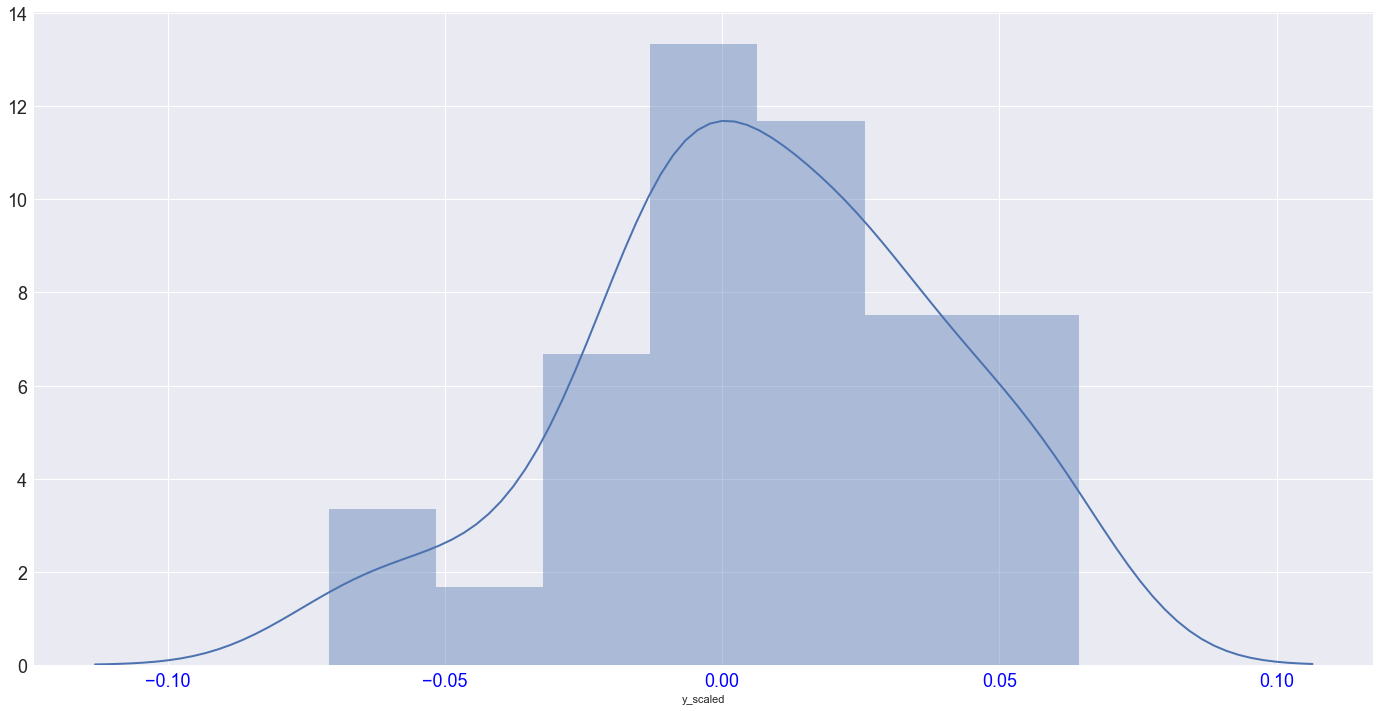

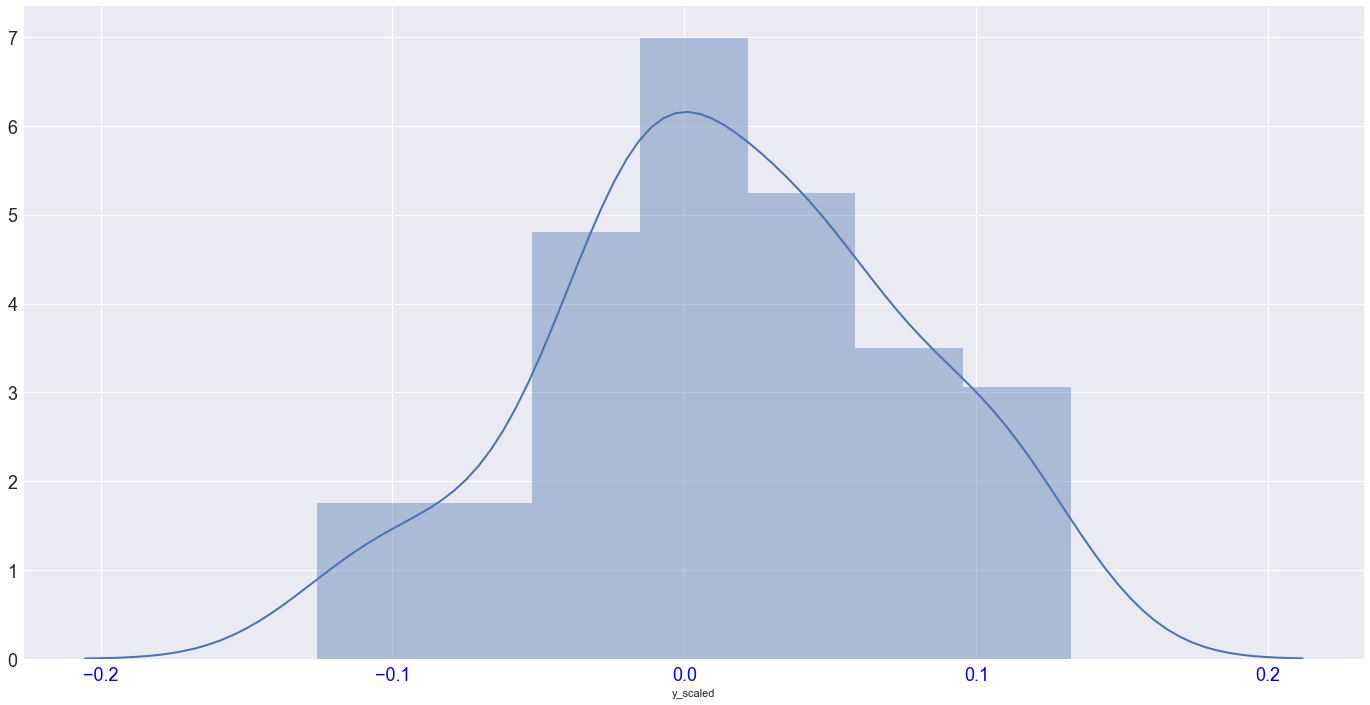

In [39]:
evaluate(ts_data[0]["future"]["y_scaled"], y_pred_mean)
sns.distplot(y_pred_mean - y_true)
plt.show()
sns.distplot((y_pred_mean - y_true)/y_true)
plt.show()

Inferred posterior k: mean = 0.034498, stddev = 0.014370
Inferred posterior m: mean = 0.523365, stddev = 0.009905
Inferred posterior tau: mean = 0.024190, stddev = 0.018489
Inferred posterior noise: mean = 0.232393, stddev = 0.320116


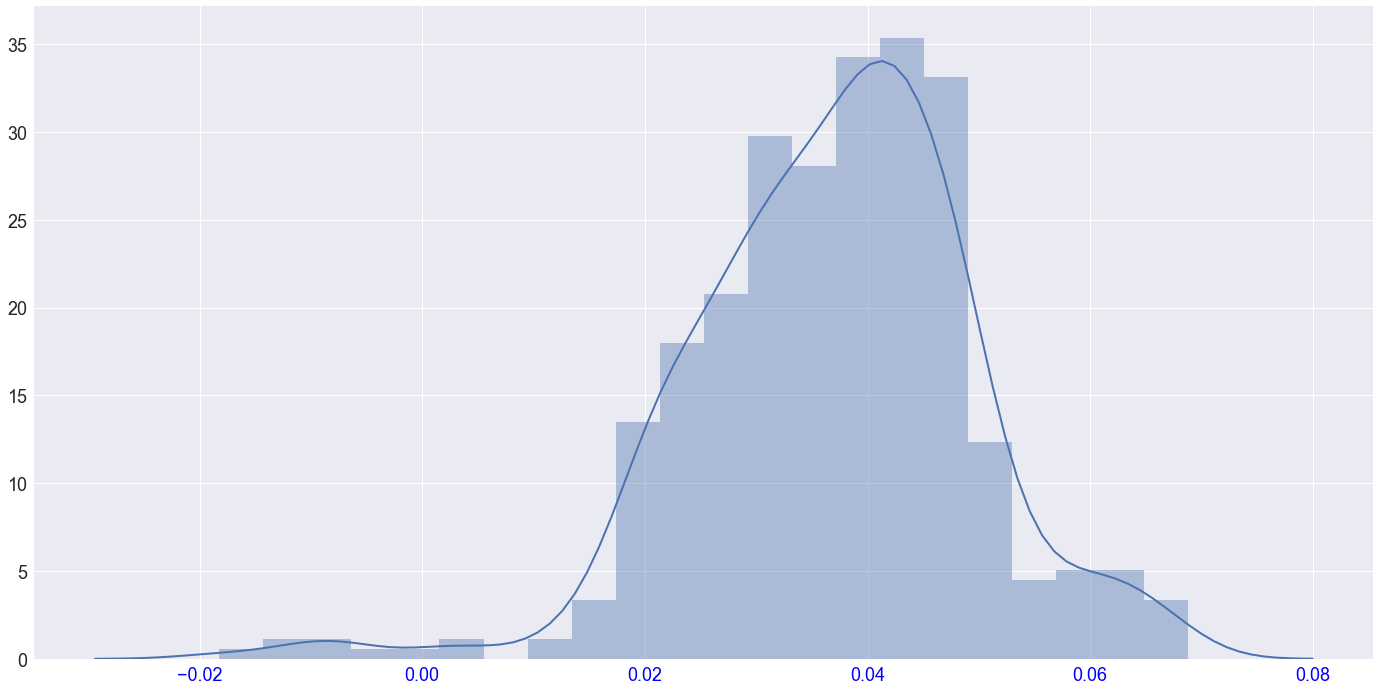

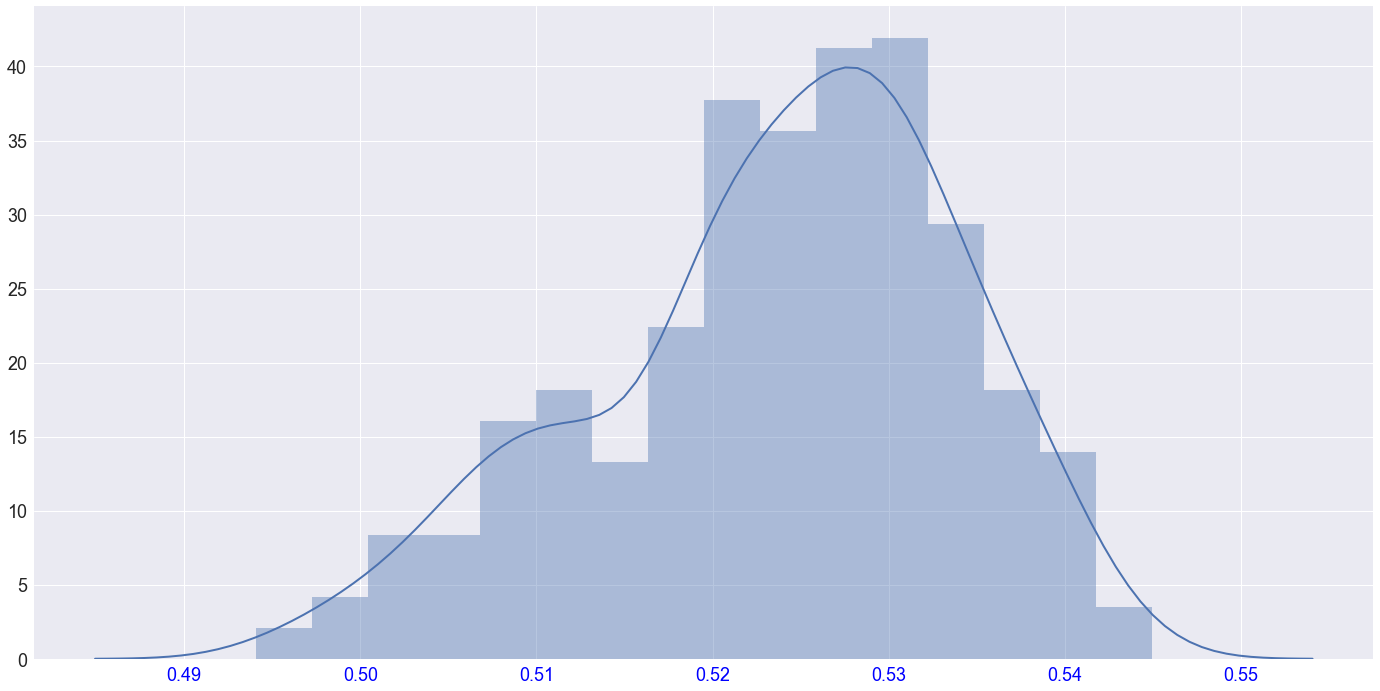

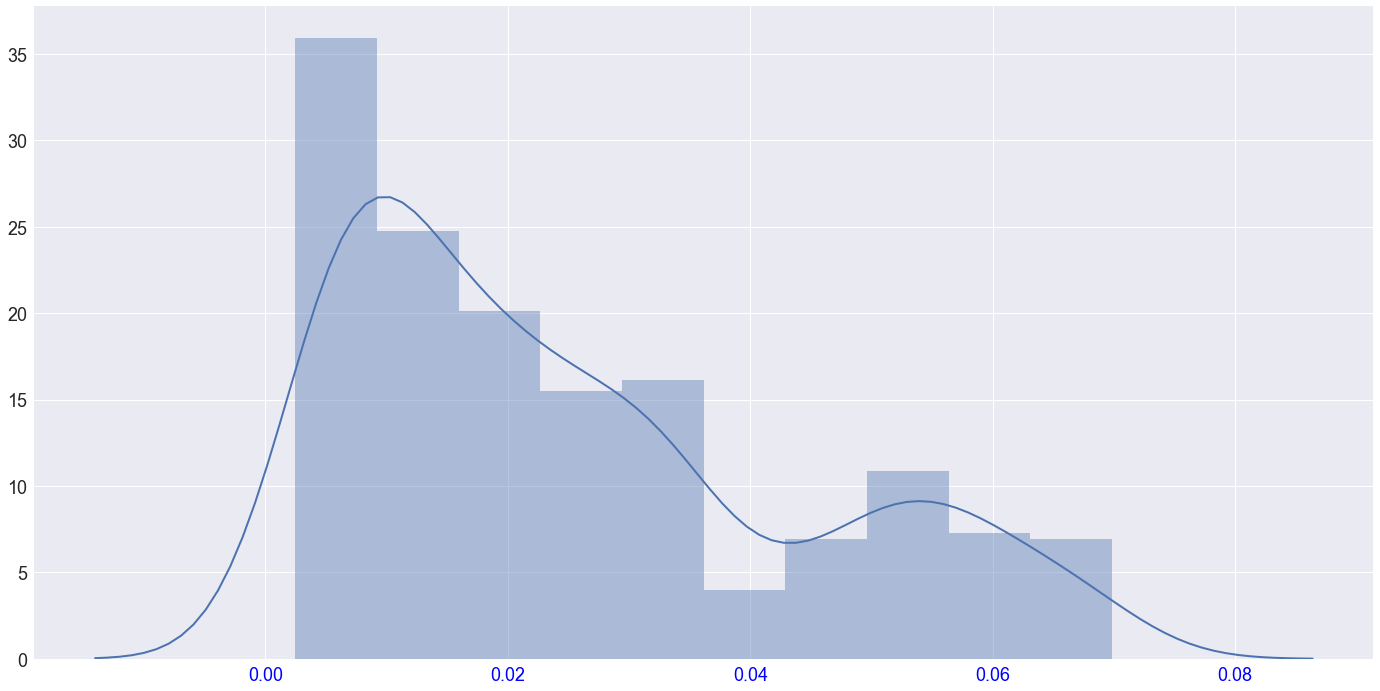

In [17]:
# Posterior check
sess = ed.get_session()
kmean, kstddev = sess.run([qk.mean(), qk.stddev()])
print("Inferred posterior k: mean = %f, stddev = %f" % (kmean, kstddev))
mmean, mstddev = sess.run([qm.mean(), qm.stddev()])
print("Inferred posterior m: mean = %f, stddev = %f" % (mmean, mstddev))
tau_mean, tau_stddev = sess.run([qtau.mean(), qtau.stddev()])
print("Inferred posterior tau: mean = %f, stddev = %f" % (tau_mean, tau_stddev))


noise_mean, noise_stddev = sess.run([qsigma_obs.mean(), qsigma_obs.stddev()])
print("Inferred posterior noise: mean = %f, stddev = %f" % (noise_mean, noise_stddev))

nburn = 500
stride = 10
sns.distplot(qk.params.eval()[nburn:ITR:stride])
plt.show()
sns.distplot(qm.params.eval()[nburn:ITR:stride])
plt.show()

sns.distplot(qtau.params.eval()[nburn:ITR:stride])
plt.show()

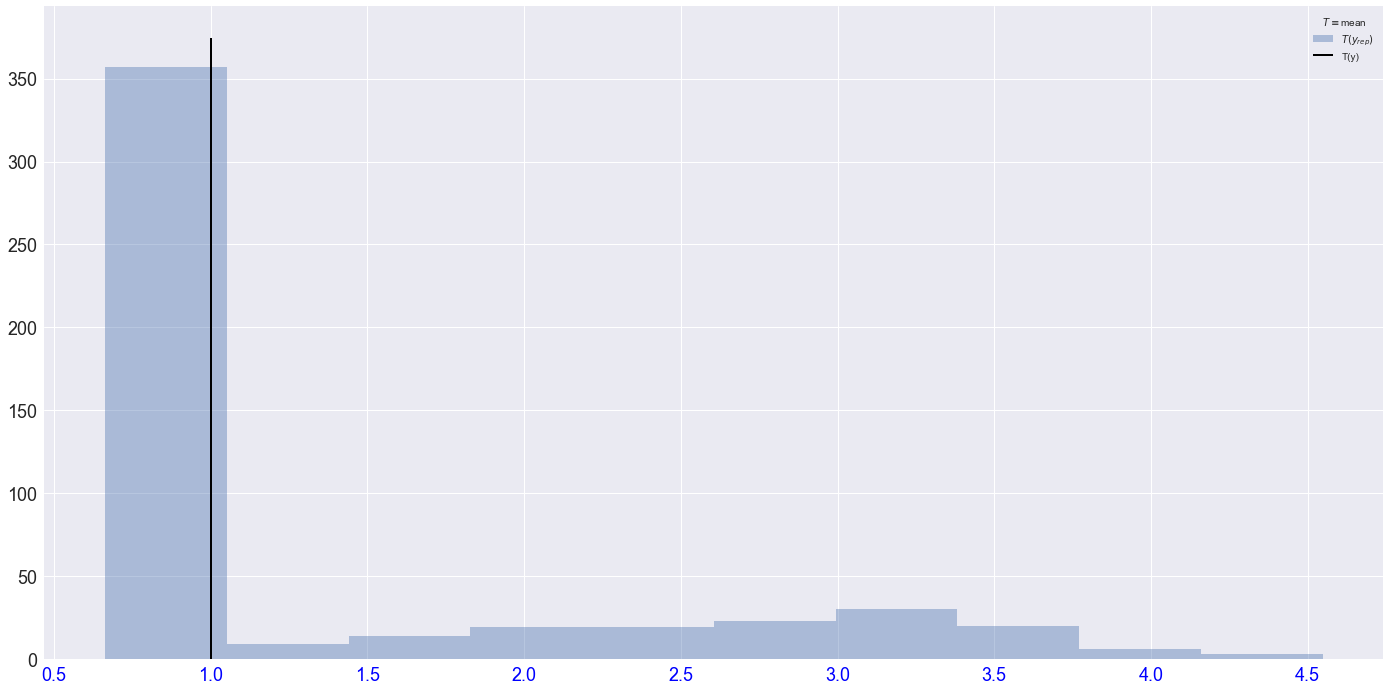

In [35]:
y_post = ed.copy(y, posts_dict)
ty_rep, ty = ed.ppc(lambda xs, zs: tf.reduce_max(tf.cast(xs[y_post], tf.float32)), 
       data={y_post:ts_data[0]["history"]["y_scaled"].as_matrix(), 
            t: train_data['t'],
            A: train_data['A'], 
            X: train_data['X'].as_matrix(), 
            sigmas: train_data['sigmas'], 
            t_change: train_data["t_change"]},n_samples=500)    

# y: ts_data[0]["history"]["y_scaled"].as_matrix(),
#     t: train_data["t"],
#     X: train_data["X"],
#     sigmas: train_data["sigmas"],
#     A: train_data["A"],
#     t_change: train_data["t_change"]

ed.ppc_stat_hist_plot(
    ty[0], ty_rep, stat_name=r'$T \equiv$mean', bins=10)
plt.show()

w 68% confidence bounds: 0.028637878000736236 | 0.03634076379239559 | 0.0422996199131012
b 68% confidence bounds: 0.5201637411117553 | 0.5236485302448273 | 0.5280705380439759


## Round 1.5: 
___

### Improvements
- motify init k and m
- remove holiday features why us public holiday not works, require in-domain knowledge
- tau from fixed value to latent variable

## Round 2: 
___
### 2.Model
We modify the model by creating global latent variable inferring local seasonality  
- Local latend variable
    - 
- Global latent variable
    - `gbeta`
    
Given train data, the goal is to infer $k,m,\boldsymbol{\delta},\tau,\boldsymbol{\beta}$ and $\sigma$, where k and m are trend model parameters, $\boldsymbol{\delta}$ are latent variables for rate adjustment, $\boldsymbol{\beta}$ are smoothers for seasonality, $\tau$ and $\sigma$ are variance component parameters.

## Conclusion and Lessions Learned